# Tutorial Category Features

In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns

<br>

## Input

In [3]:
# the path that contains the data
path = os.path.expandvars("~/Dropbox_RSM/teaching/big-data-23-24/data/dr-s")

In [4]:
# INPUT
training_week = 88  # for model training
target_customers = list(range(2000))
target_products = list(range(250))

<br>

## Load data

In [5]:
baskets = pd.read_parquet(f"{path}/upload/baskets-m.parquet")
baskets.head()

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


<br>

## Product-category map

Keep in mind that you need some evidence that motivates your product-category map. For example, you assume that products from the same category do not occur in the same shopping basket. 

### Co-occurrences

In [6]:
baskets["basket"] = baskets["customer"] * 1000000 + baskets["week"]

In [7]:
# create a (binary) space matrix that indicates whether a basket (row) contains a product (col)
# co-occurrences are the dot produdct of this basket-product matrix
# return data frame
def get_co_occurrences(x, variable_basket="basket", variable_product="product"):
    row = x[variable_basket].values
    col = x[variable_product].values
    dim = (x[variable_basket].max() + 1, x[variable_product].max() + 1)

    basket_product_table = scipy.sparse.csr_matrix(
        (np.ones(len(row), dtype=int), (row, col)), shape=dim
    )
    co_occurrences_sparse = basket_product_table.T.dot(basket_product_table).tocoo()
    co_occurrences_df = pd.DataFrame(
        {
            "product_1": co_occurrences_sparse.row,
            "product_2": co_occurrences_sparse.col,
            "co-occurrence": co_occurrences_sparse.data,
        }
    )
    return co_occurrences_df

In [8]:
co_occurrences = get_co_occurrences(baskets)
co_occurrences.head()

,product_1,product_2,co-occurrence
0,208,0,60
1,233,0,13
2,59,0,28
3,71,0,35
4,70,0,100


In [9]:
# example: products 0 to 9 do not co-occur with each other (they only occur with themselves)
co_occurrences[
    (co_occurrences["product_1"].isin(range(10)))
    & (co_occurrences["product_2"].isin(range(10)))
]

,product_1,product_2,co-occurrence
240,0,0,16428
481,1,1,53011
722,2,2,16938
963,3,3,6740
1204,4,4,21586
1445,5,5,16538
1686,6,6,24437
1927,7,7,21904
2168,8,8,21342
2409,9,9,19516


In [10]:
# same for products 10 to 19
co_occurrences[
    (co_occurrences["product_1"].isin(range(10, 20)))
    & (co_occurrences["product_2"].isin(range(10, 20)))
]

,product_1,product_2,co-occurrence
2650,10,10,24592
2891,11,11,37954
3132,12,12,17731
3373,13,13,24917
3614,14,14,16524
3855,15,15,22884
4096,16,16,29001
4336,17,17,10248
4578,18,18,6687
4819,19,19,19649


In [11]:
J = co_occurrences["product_1"].nunique()

In [12]:
cooccurrence_matrix = np.zeros((J, J))

cooccurrence_matrix[
    co_occurrences["product_1"], co_occurrences["product_2"]
] = co_occurrences["co-occurrence"]

np.fill_diagonal(cooccurrence_matrix, 0)

In [ ]:
cooccurrence_matrix /= np.max(cooccurrence_matrix)

In [20]:
cooccurrence_matrix = 1 - cooccurrence_matrix

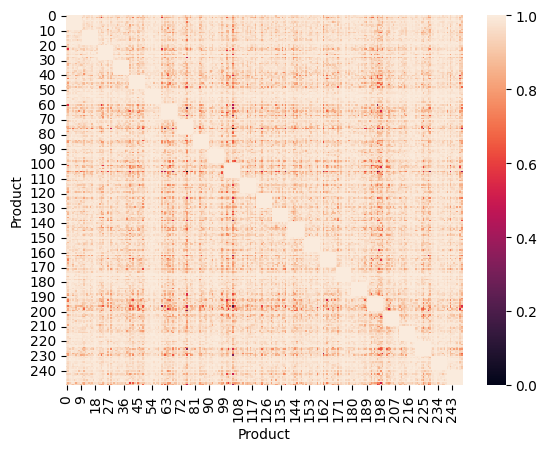

In [24]:
sns.heatmap(cooccurrence_matrix)
plt.xlabel("Product")
plt.ylabel("Product")
plt.show()

### Derived category-product map

We will use this category-product map below.

In [26]:
category_product_map = pd.DataFrame(
    {
        "product": list(range(250)),
        "category": np.repeat(range(25), 10),
    }
)

<br>

## Building category features

### Step 1: Merge category ID to basket data

Note: you can do the same with coupon data, e.g., when building a binary feature "is there a coupon for a customer-week-category combination (1) or not (0)".

In [27]:
# add category id to basket data
baskets = baskets.merge(category_product_map, on="product")

In [28]:
baskets.head()

,week,customer,product,price,basket,category
0,0,0,71,629,0,7
1,0,47,71,629,47000000,7
2,0,55,71,629,55000000,7
3,0,96,71,629,96000000,7
4,0,110,71,629,110000000,7


In [29]:
# Example "Purchase frequencies" from lecture

# Customer A:
# Product A    0 0 1 0 0 ? 0 0 1 0  -> 2  -> 20% / recency: 2 weeks
# Product B    0 0 ? 0 0 1 0 0 ? 0  -> 1  -> 10% / recency: 5 weeks
# ------------
# Category 1   0 0 1 0 0 1 0 0 1 0  -> 3  -> 30% / recency: 2 weeks

# Customer B:
# Product A    0 0 1 0 0 1 0 0 1 0  -> 3  -> 30%
# Product B    0 0 0 0 0 0 0 0 0 0  -> 0  -> 0%
# ------------
# Category 1   0 0 1 0 0 1 0 0 1 0  -> 3  -> 30%

### Step 2: Build category-level feature(s)

In [30]:
# important: only use data before training week!!!
baskets_train = baskets[baskets["week"] < training_week]

In [31]:
n_weeks = baskets_train.week.nunique()

In [32]:
# customer-product feature
purchase_frequency_ij = (
    (
        baskets_train.groupby(["customer", "product"])[
            ["week"]
        ].count()  # number of weeks with purchase
        / n_weeks  # number of weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.090909
1,0,11,0.102273
2,0,15,0.011364
3,0,16,0.034091
4,0,21,0.011364
...,...,...,...
703995,9999,231,0.011364
703996,9999,235,0.125000
703997,9999,237,0.056818
703998,9999,243,0.022727


In [33]:
# customer-category feature
purchase_frequency_ic = (
    (
        baskets_train.groupby(["customer", "category"])[
            ["week"]
        ].count()  # number of weeks with purchase
        / n_weeks  # number of weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ic

,customer,category,probability
0,0,0,0.090909
1,0,1,0.147727
2,0,2,0.011364
3,0,3,0.068182
4,0,4,0.034091
...,...,...,...
241081,9999,20,0.295455
241082,9999,21,0.420455
241083,9999,22,0.045455
241084,9999,23,0.193182


### Compare features

In [34]:
purchase_frequency_i = purchase_frequency_ij.merge(
    category_product_map, on="product"
).merge(
    purchase_frequency_ic,
    on=["customer", "category"],
    suffixes=["_product", "_category"],
)

In [35]:
purchase_frequency_i[
    (purchase_frequency_i["customer"] == 1) & (purchase_frequency_i["category"] == 2)
]

,customer,product,probability_product,category,probability_category
30613,1,21,0.397727,2,0.806818
30614,1,22,0.363636,2,0.806818
30615,1,28,0.045455,2,0.806818


### Step 3: Merge features to base table

In [36]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):
    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [37]:
base_table = build_target(baskets, training_week).merge(
    category_product_map, on="product"
)
base_table

,week,customer,product,y,category
0,88,0,0,0,0
1,88,1,0,0,0
2,88,2,0,0,0
3,88,3,0,0,0
4,88,4,0,0,0
...,...,...,...,...,...
499995,88,1995,249,0,24
499996,88,1996,249,1,24
499997,88,1997,249,0,24
499998,88,1998,249,0,24


In [38]:
base_table = base_table.merge(
    purchase_frequency_ic, on=["customer", "category"], how="left"
).fillna(
    0
)  # note that we need to add missing values!

## Summary

Do you see the parallels to the tutorial?

We need to do the following steps:
1. Build the base table
1. Make sure all index variables (customer, category) are in the source data (baskets) and the base table
1. Build a feature at the desired level (here customer-category)
1. Merge the features to the base table ("left join"), fill missing values

<br>
<br>

<br>
<br>

<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>